# Libraries Used

In [1]:
"""
Importing necessary libraries for data manipulation, visualization, 
machine learning, speech recognition, and logging.
"""

# Data handling and numerical operations
import pandas as pd
import numpy as np
import os
import pickle  # For saving and loading models

# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Machine learning tools
from sklearn.model_selection import train_test_split  # Splitting dataset
from sklearn.preprocessing import StandardScaler  # Feature scaling
from sklearn.metrics import mean_absolute_error, r2_score  # Model evaluation metrics
from sklearn.svm import SVR  # Support Vector Regression model

# Speech modules for voice input/output
import speech_recognition as sr  # To convert speech to text
import pyttsx3  # Text-to-speech conversion

# Utilities
import re  # Regular expressions for text processing
from scipy.stats import zscore  # Outlier detection using Z-score
import logging  # Logging errors and information for debugging
from statistics import mean,median,mode  # Statistical functions for data analysis  






# Data Preprocessing
In this class we gonna do some features of Data preprocessing to under stand the Data

In [2]:



class DataPreprocessor:
    def __init__(self, filepath):
        """
        Load the dataset from the given file path and initialize necessary variables.
        
        Parameters:
        filepath (str): Path to the CSV file containing the dataset.
        """
        self.data = pd.read_csv(filepath)
        self.X = None  # Features
        self.y = None  # Target
        self.scaler = None  # For feature scaling

    def show_data(self, numbers=5, mode='head'):
        """
        Display various summaries of the dataset depending on the selected mode.
        
        Parameters:
        numbers (int): Number of rows to show for head, tail, or sample.
        mode (str): Mode to choose summary: 'head', 'tail', 'info', 'describe', etc.
        
        Returns:
        Various outputs depending on the mode.
        """
        modefilter = mode.lower().strip()
        data = self.data

        # Choose the appropriate action based on the mode
        if modefilter == 'head':
            return data.head(numbers)
        elif modefilter == 'tail':
            return data.tail(numbers)
        elif modefilter == 'info':
            return data.info()
        elif modefilter == 'describe':
            return data.describe()
        elif modefilter == 'shape':
            return data.shape
        elif modefilter == 'columns':
            return data.columns.tolist()
        elif modefilter == 'datatypes':
            return data.dtypes
        elif modefilter == 'sample':
            return data.sample(numbers)
        else:
            raise ValueError("Invalid mode. Choose from 'head', 'tail', 'info', 'describe', 'shape', 'columns', 'datatypes', or 'sample'.")

    def remove_outliers(self, z_thresh=3):
        """
        Remove rows in the dataset that are statistical outliers using Z-score method.
        
        Parameters:
        z_thresh (float): Z-score threshold for identifying outliers. Default is 3.
        """
        logging.info("Removing outliers using z-score")

        # Select only numeric columns
        numeric_data = self.data.select_dtypes(include=[float, int])

        # Compute z-scores and filter out rows with any column having z-score > threshold
        z_scores = zscore(numeric_data)
        self.data = self.data[(abs(z_scores) < z_thresh).all(axis=1)]

    def clean_data(self):
        """
        Clean and prepare the dataset:
        - Fill missing values with the mean (numeric only)
        - Encode binary yes/no features to 1/0
        - One-hot encode categorical columns like 'furnishingstatus'
        - Separate features (X) and target (y)
        """
        # Fill missing values with column means
        self.data.fillna(self.data.mean(numeric_only=True), inplace=True)

        # Binary yes/no columns mapped to 1/0
        binary_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
        for col in binary_cols:
            if col in self.data.columns:
                self.data[col] = self.data[col].map({'yes': 1, 'no': 0})

        # One-hot encoding for 'furnishingstatus' (if exists)
        if 'furnishingstatus' in self.data.columns:
            self.data = pd.get_dummies(self.data, columns=['furnishingstatus'], drop_first=True)

        # Split into features and target
        if 'price' in self.data.columns:
            self.X = self.data.drop('price', axis=1)
            self.y = self.data['price']
        else:
            raise KeyError("Target column 'price' not found in dataset.")

    def scale_features(self):
        """
        Apply StandardScaler to scale all features in the dataset.
        
        Returns:
        scaler (StandardScaler): Fitted scaler instance for later use.
        """
        logging.info("Scaling features using StandardScaler")
        
        # Initialize and fit the scaler
        self.scaler = StandardScaler()
        self.X = self.scaler.fit_transform(self.X)
        
        return self.scaler

    def inverse_transform_input(self, X_scaled):
        """
        Inverse transform scaled input back to original feature values.
        
        Parameters:
        X_scaled (np.array): Scaled input features.
        
        Returns:
        np.array: Original feature values.
        """
        logging.info("Inverse transforming scaled input")
        return self.scaler.inverse_transform(X_scaled)

    def split_data(self):
        """
        Split dataset into training and testing sets.
        
        Returns:
        tuple: X_train, X_test, y_train, y_test (80/20 split)
        """
        return train_test_split(self.X, self.y, test_size=0.2, random_state=42)

    def compute_statistics(self, column_name):
        """
        Compute basic statistics: mean, median, and mode for the given column.
        
        Parameters:
        column_name (str): Column name to compute statistics for.
        
        Returns:
        dict: Dictionary containing mean, median, and mode.
        """
        if column_name not in self.data.columns:
            raise ValueError(f"Column '{column_name}' not found in dataset.")
        
        col_data = self.data[column_name].dropna()  # Remove missing values before computing

        try:
            avg = mean(col_data)
            mid = median(col_data)
            freq = mode(col_data)
            
            return {
                'mean': round(avg, 2),
                'median': round(mid, 2),
                'mode': freq
            }
        except Exception as e:
            # Handle cases where mode or other stat can't be computed
            logging.error(f"Error computing statistics for {column_name}: {e}")
            return {"error": str(e)}


In [3]:
"""
Class: DataAnalyzer

Purpose:
---------
This class is designed to perform a variety of exploratory data analysis (EDA) tasks 
on a pandas DataFrame. It helps understand the structure, quality, and nature of the data.

Reason:
--------
Before building any machine learning model, it's critical to understand the data. 
This class provides comprehensive summaries and checks including data types, 
missing values, zero counts, categorical distributions, cardinality, and outliers.
"""

class DataAnalyzer:
    def __init__(self, data: pd.DataFrame):
        """
        Initializes the DataAnalyzer with a given pandas DataFrame.
        
        Parameters:
        -----------
        data : pd.DataFrame
            The dataset to analyze.
        """
        self.data = data

    def data_types_summary(self):
        """
        Displays the count of each data type in the dataset.

        Reason:
        -------
        Helps to understand the composition of the dataset and 
        how many features are numerical vs categorical.
        """
        print(f"\n🧬 Data Types Summary:")
        print(self.data.dtypes.value_counts())

    def missing_values_summary(self):
        """
        Displays the total number of missing (null) values per column.

        Reason:
        -------
        Identifies incomplete data that may need cleaning or imputation.
        """
        print(f"\n🚨 Missing Values Summary:")
        missing = self.data.isnull().sum()
        print(missing[missing > 0])

    def zero_values_summary(self):
        """
        Shows how many zero values exist in each column.

        Reason:
        -------
        Zeros may indicate absence or may be invalid (e.g., zero income),
        so this check highlights possible data issues.
        """
        print(f"\n🔎 Zero Values Summary:")
        print((self.data == 0).sum())

    def value_counts_summary(self):
        """
        Shows the count of each category for categorical features.

        Reason:
        -------
        Helps understand distribution and imbalance in categorical columns.
        """
        print(f"\n🧮 Value Counts for Categorical Features:")
        categorical = self.data.select_dtypes(include=['object'])
        for col in categorical.columns:
            print(f"\n🔸 {col} value counts:")
            print(categorical[col].value_counts())

    def unique_values_summary(self):
        """
        Prints the number of unique values in each column.

        Reason:
        -------
        Indicates variability and can identify potential ID or constant columns.
        """
        print(f"\n🔢 Unique Values Per Column:")
        print(self.data.nunique())

    def feature_cardinality(self):
        """
        Displays how many unique values each column has.

        Reason:
        -------
        Helps identify high cardinality features that may be 
        problematic in encoding or modeling.
        """
        print(f"\n📏 Feature Cardinality:")
        for col in self.data.columns:
            print(f"{col}: {self.data[col].nunique()} unique values")

    def constant_columns(self):
        """
        Identifies columns that contain only one unique value.

        Reason:
        -------
        Constant columns do not contribute any information to the model 
        and should be dropped.
        """
        print(f"\n🚫 Constant Columns (Only One Unique Value):")
        for col in self.data.columns:
            if self.data[col].nunique() == 1:
                print(f"{col} is constant.")

    def duplicated_rows(self):
        """
        Counts the number of duplicated rows in the dataset.

        Reason:
        -------
        Duplicate data can bias the model and must be removed 
        for accurate analysis and training.
        """
        duplicates = self.data.duplicated().sum()
        print(f"\n📑 Number of duplicated rows: {duplicates}")

    def skewness_summary(self):
        """
        Computes skewness for numerical columns.

        Reason:
        -------
        Skewness indicates data symmetry. Highly skewed data may 
        require transformation before modeling.
        """
        print(f"\n📈 Skewness of Numerical Columns:")
        print(self.data.select_dtypes(include=np.number).skew())

    def kurtosis_summary(self):
        """
        Computes kurtosis for numerical columns.

        Reason:
        -------
        Kurtosis measures the "tailedness" of the distribution. 
        High kurtosis can indicate outliers or peakedness.
        """
        print(f"\n📉 Kurtosis of Numerical Columns:")
        print(self.data.select_dtypes(include=np.number).kurt())

    def outlier_summary(self):
        """
        Detects outliers using the IQR method for each numerical column.

        Reason:
        -------
        Outliers can negatively impact model performance. 
        Identifying them is a step toward robust preprocessing.
        """
        print(f"\n📦 Outlier Count using IQR Method:")
        num_data = self.data.select_dtypes(include=np.number)
        for col in num_data.columns:
            Q1 = num_data[col].quantile(0.25)
            Q3 = num_data[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outliers = num_data[(num_data[col] < lower_bound) | (num_data[col] > upper_bound)]
            print(f"{col}: {outliers.shape[0]} outliers")


In [4]:
"""
Class: DataVisualizer

Purpose:
---------
This class provides several plotting functions to visualize different aspects 
of the dataset using Seaborn and Matplotlib.

Reason:
--------
Visualizing data is essential in exploratory data analysis (EDA) to uncover 
patterns, trends, relationships, and outliers that might not be apparent in raw numbers.
"""

class DataVisualizer:
    def __init__(self, data):
        """
        Initializes the DataVisualizer with a given dataset.

        Parameters:
        -----------
        data : pd.DataFrame
            The dataset to visualize.
        """
        self.data = data

    def plot_distribution(self, column='price'):
        """
        Plots the distribution of a specified numerical column using a histogram and KDE.

        Parameters:
        -----------
        column : str
            The name of the column to plot (default is 'price').

        Reason:
        -------
        Helps understand the distribution (normal, skewed, etc.) of a feature,
        which informs feature engineering and model selection.
        """
        plt.figure(figsize=(10, 6))
        sns.histplot(self.data[column], kde=True, color='skyblue')
        plt.title(f'Distribution of {column}')
        plt.show()

    def plot_correlation_heatmap(self):
        """
        Displays a heatmap of the correlation matrix between numerical features.

        Reason:
        -------
        Identifies multicollinearity between features and shows which variables
        are strongly positively or negatively correlated.
        """
        plt.figure(figsize=(12, 8))
        sns.heatmap(self.data.corr(), annot=True, cmap='coolwarm')
        plt.title('Correlation Heatmap')
        plt.show()

    def plot_pairplot(self, columns=None):
        """
        Plots pairwise scatterplots and histograms for a subset of numerical features.

        Parameters:
        -----------
        columns : list or None
            The list of numerical columns to include. If None, selects the first 5 numeric columns.

        Reason:
        -------
        Helps reveal relationships, clusters, and trends between variables.
        Also highlights potential collinearity or redundant features.
        """
        if columns is None:
            columns = self.data.select_dtypes(include='number').columns[:5]
        sns.pairplot(self.data[columns])
        plt.suptitle('Pairwise Relationships', y=1.02)
        plt.show()

    def plot_boxplot(self, column='price', by='bedrooms'):
        """
        Plots a boxplot of a numerical column grouped by a categorical or discrete variable.

        Parameters:
        -----------
        column : str
            The target numerical column to visualize.
        by : str
            The categorical or group-by feature.

        Reason:
        -------
        Highlights the distribution, central tendency, and outliers of a variable
        across different categories.
        """
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=by, y=column, data=self.data)
        plt.title(f'{column} by {by}')
        plt.show()

    def plot_countplot(self, column='bedrooms'):
        """
        Plots a countplot (bar chart) for a categorical or discrete feature.

        Parameters:
        -----------
        column : str
            The column to count and visualize.

        Reason:
        -------
        Gives an overview of the frequency distribution of a categorical variable,
        helping detect imbalance in the dataset.
        """
        plt.figure(figsize=(8, 5))
        sns.countplot(data=self.data, x=column)
        plt.title(f'Count of {column}')
        plt.show()


In [5]:
"""
Class: UnivariateAnalysis (inherits from DataVisualizer)

Purpose:
---------
Performs univariate analysis on a dataset, focusing on one variable at a time.

Reason:
--------
Univariate analysis helps understand the distribution and central tendencies of individual variables.
It is the first step in EDA, allowing detection of outliers, skewness, and imbalances.
"""

class UnivariateAnalysis(DataVisualizer):
    def summary_statistics(self):
        """
        Prints summary statistics for all numerical columns.

        Reason:
        -------
        Provides basic descriptive stats (mean, median, std, min, max, etc.) 
        to understand the central tendency and spread of each feature.
        """
        print("Summary Statistics of Univariate Analysis:")
        print(self.data.describe())

    def plot_all_univariate(self):
        """
        Plots the distribution of all numerical columns and the countplot for a common categorical column.

        Reason:
        -------
        Visualization of individual features is essential to check if the data is normally distributed,
        identify skewed data, or detect anomalies such as spikes or outliers.
        """
        print("Plotting all univariate distributions:")

        # Plot distribution for target column
        self.plot_distribution('price')

        # Plot distributions for all numeric features
        numeric_columns = self.data.select_dtypes(include='number').columns
        for col in numeric_columns:
            self.plot_distribution(col)

        # Plot count of a common categorical feature
        self.plot_countplot('bedrooms')


In [6]:
"""
Class: BivariateAnalysis (inherits from DataVisualizer)

Purpose:
---------
Performs bivariate analysis to explore relationships between two variables 
at a time — typically one independent and one dependent.

Reason:
--------
Bivariate analysis helps identify dependencies, correlations, or patterns 
between variables, which are critical for feature selection and understanding 
data structure before modeling.
"""

class BivariateAnalysis(DataVisualizer):
    def correlation_matrix(self):
        """
        Prints the correlation matrix for numerical columns.

        Reason:
        -------
        Shows how strongly variables are related to each other.
        Useful for identifying multicollinearity and selecting 
        relevant predictors for modeling.
        """
        print("Correlation Matrix of Bivariate Analysis:")
        print(self.data.corr())

    def plot_all_bivariate(self):
        """
        Generates several bivariate plots including:

        - Correlation heatmap: to visualize variable relationships.
        - Pairplot: to explore pairwise distributions.
        - Boxplot: to compare price across categories (e.g., number of bedrooms).

        Reason:
        -------
        These visualizations help uncover meaningful patterns and interactions 
        between features and the target variable (e.g., price).
        """
        self.plot_correlation_heatmap()
        self.plot_pairplot()
        self.plot_boxplot(column='price', by='bedrooms')


# Model Training
here we gonna Train models and will follow the several techniques
- training a model
- evaluation
- saving model in pickle file

In [7]:
"""
Class: ModelTrainer

Purpose:
---------
Handles training, evaluating, and saving of a machine learning model using Support Vector Regression (SVR).

Reason:
--------
Encapsulating model training in a class keeps the workflow modular, reusable, and organized.
This structure allows for clean integration into larger ML pipelines.
"""

class ModelTrainer:
    def __init__(self, X_train, y_train, scaler, columns):
        """
        Initializes the ModelTrainer with training data, scaler, and column information.

        Parameters:
        -----------
        X_train : np.ndarray or pd.DataFrame
            Feature matrix for training.
        y_train : np.ndarray or pd.Series
            Target values for training.
        scaler : sklearn.preprocessing object
            Scaler used for feature normalization.
        columns : list
            List of feature column names (used for future reference).
        
        Reason:
        -------
        Keeping the scaler and column info ensures consistent preprocessing 
        during model deployment or prediction.
        """
        self.X_train = X_train
        self.y_train = y_train
        self.scaler = scaler
        self.columns = columns
        self.model = SVR(kernel='rbf')  # Using Radial Basis Function kernel

    def train_model(self):
        """
        Fits the SVR model using the training data.

        Reason:
        -------
        This is the core learning step where the model is trained to find patterns
        between input features and target values.
        """
        self.model.fit(self.X_train, self.y_train)
        print("Model trained successfully!")

    def evaluate(self, X_test, y_test):
        """
        Evaluates the trained model using Mean Absolute Error and R² Score.

        Parameters:
        -----------
        X_test : np.ndarray or pd.DataFrame
            Test feature data.
        y_test : np.ndarray or pd.Series
            True test target values.

        Reason:
        -------
        Evaluation metrics help assess the model's performance. 
        MAE tells how far predictions are from actual values on average, 
        while R² shows how well the model explains variance.
        """
        predictions = self.model.predict(X_test)
        mae = mean_absolute_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)
        print(f" MAE: {mae:.2f}")
        print(f"R² Score: {r2:.2f}")

    def save_model(self, filepath):
        """
        Saves the trained model, scaler, and column info as a pickle file.

        Parameters:
        -----------
        filepath : str
            The path where the model file should be saved.

        Reason:
        -------
        Storing the model with its preprocessing objects allows it to be 
        loaded later for inference or further training without repeating setup steps.
        """
        os.makedirs(os.path.dirname(filepath), exist_ok=True)
        with open(filepath, 'wb') as f:
            pickle.dump({
                'model': self.model,
                'scaler': self.scaler,
                'columns': self.columns
            }, f)
        print(f"Model, scaler, and columns saved to: {filepath}")


# Complete end to end pipline
This defines a function named run_pipeline, which is my end-to-end pipeline for:

- Loading data

- Cleaning and preparing it

- Training a model

- Evaluating and saving the model

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB
      price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0  13300000  7420         4          2        3      yes        no       no

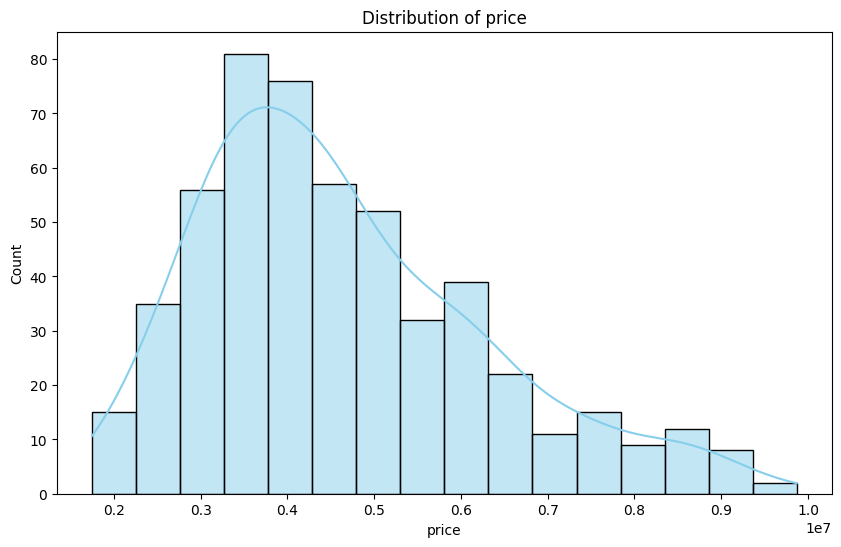

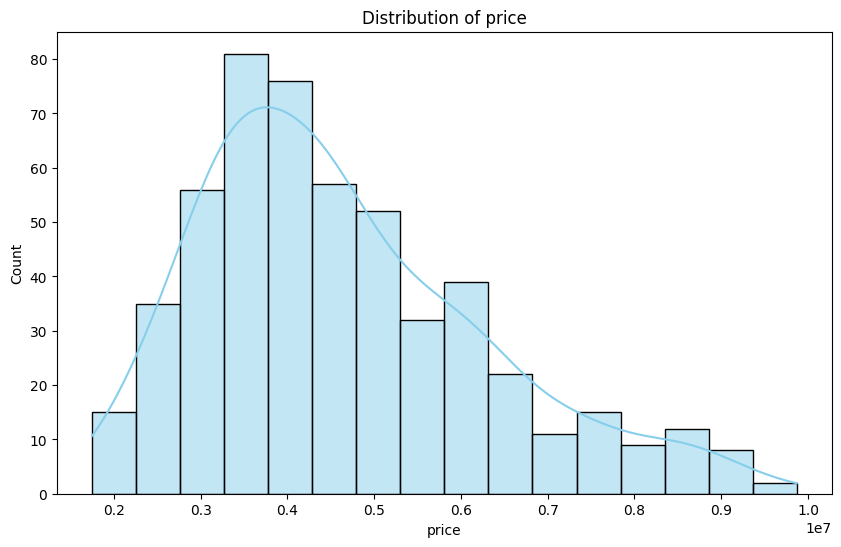

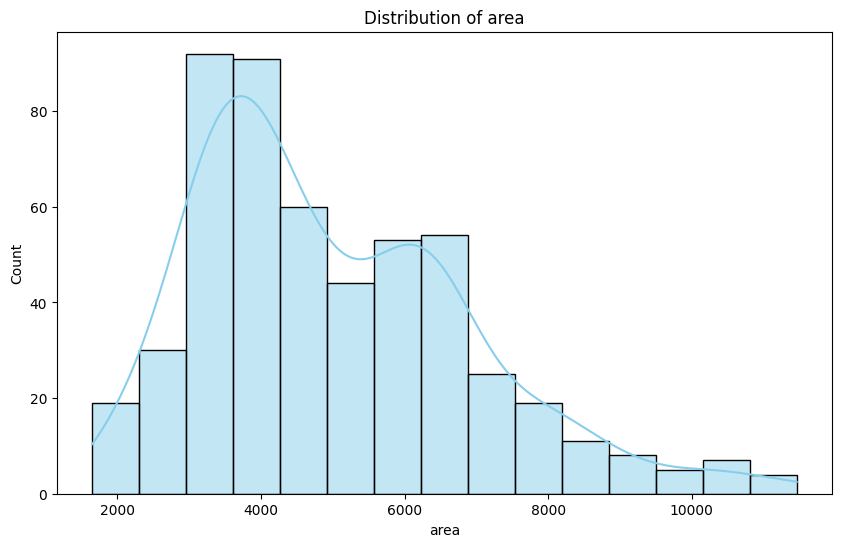

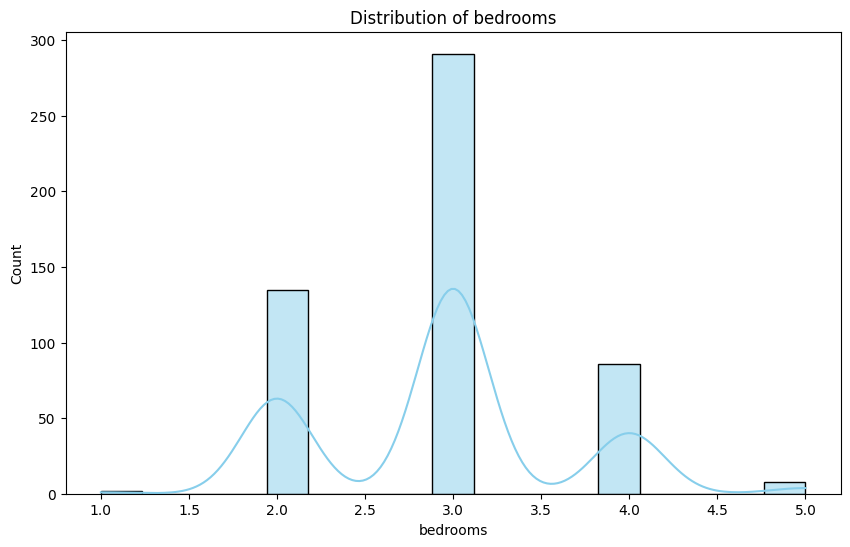

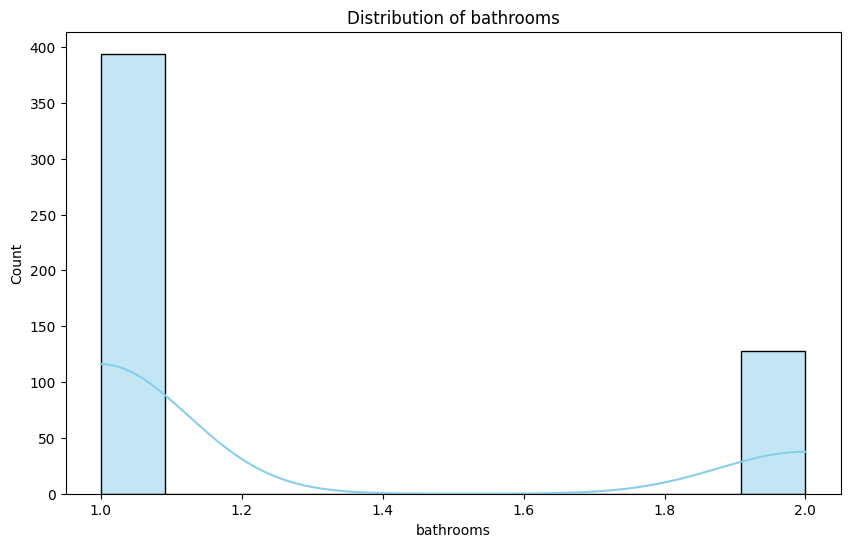

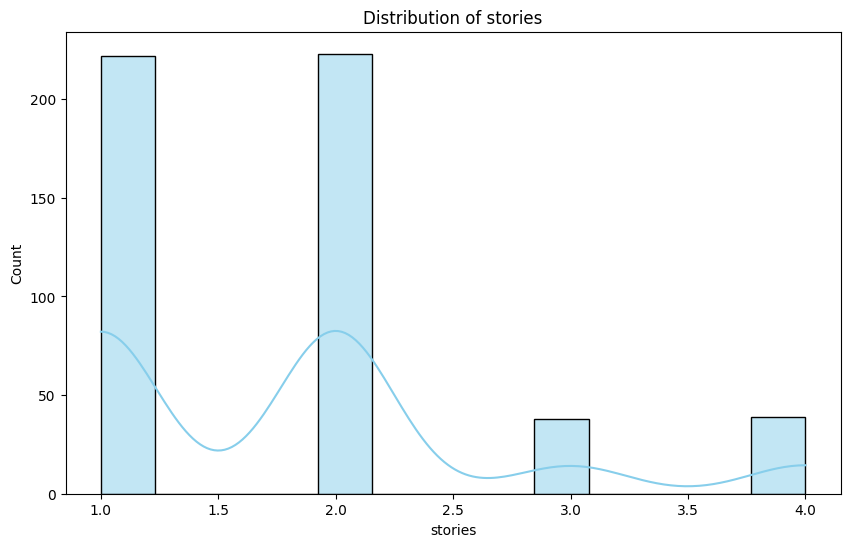

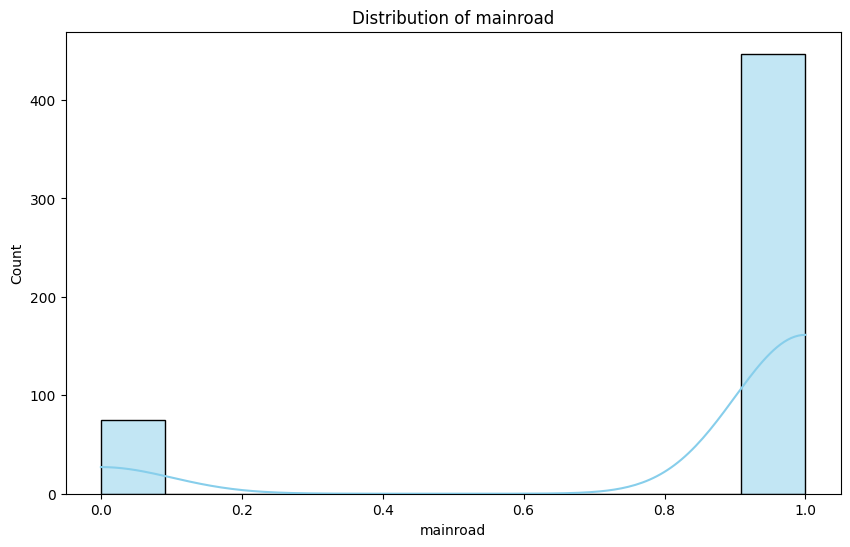

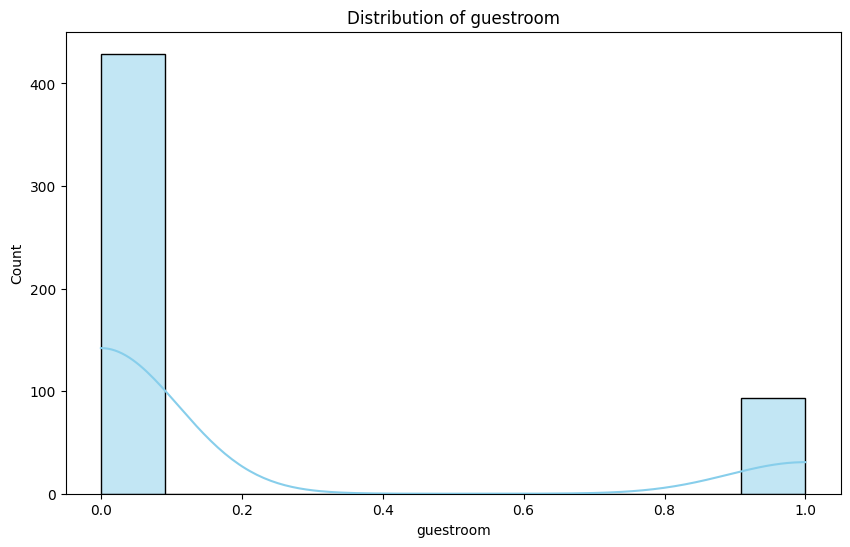

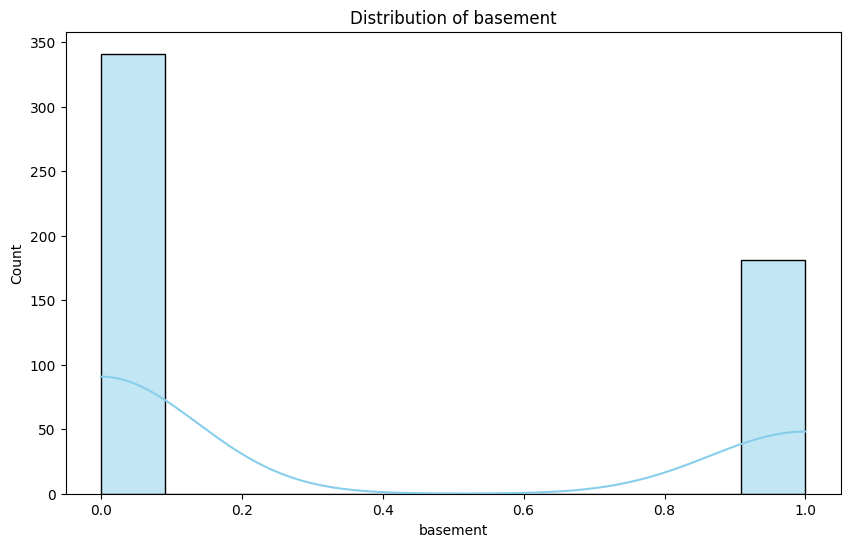

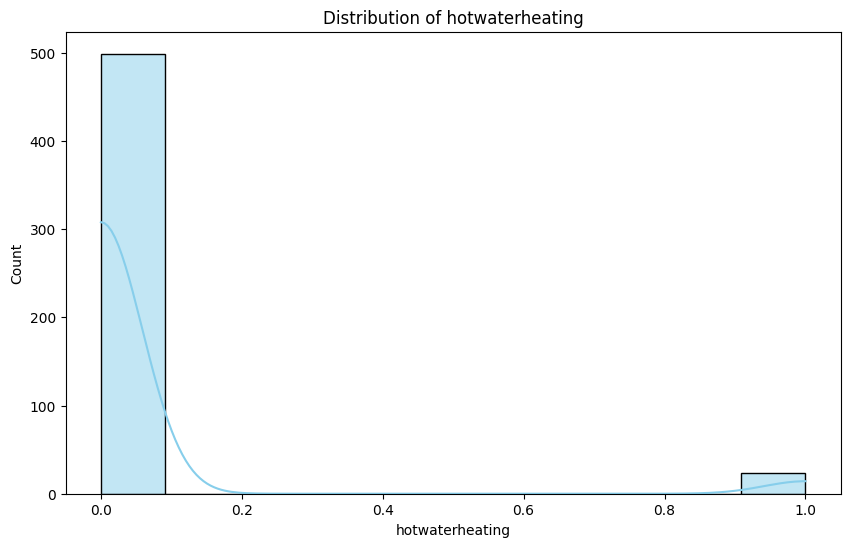

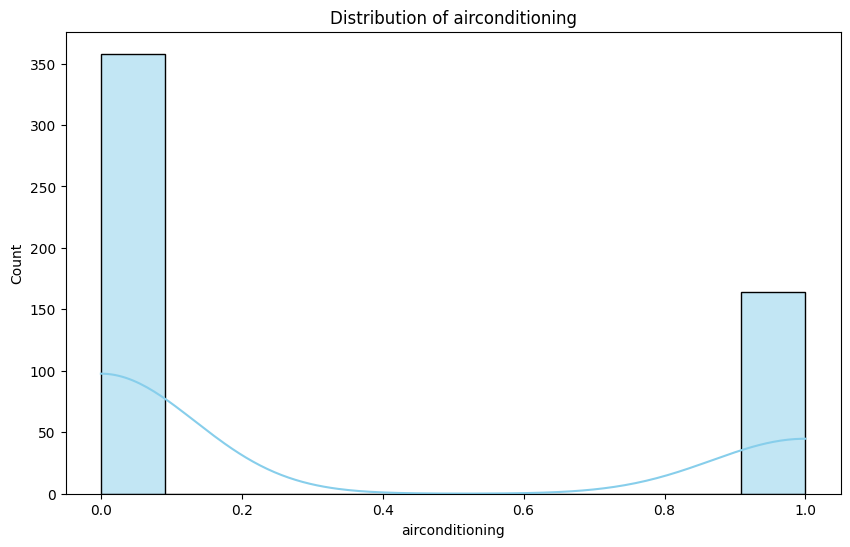

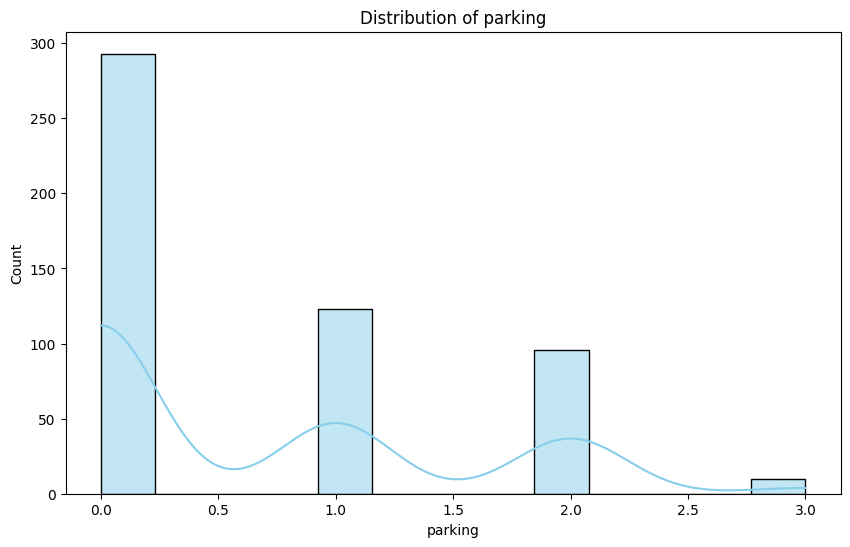

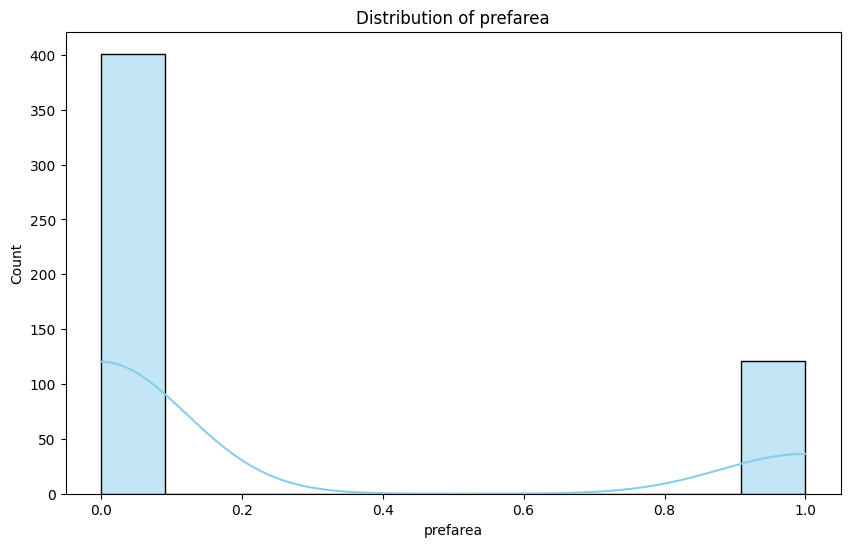

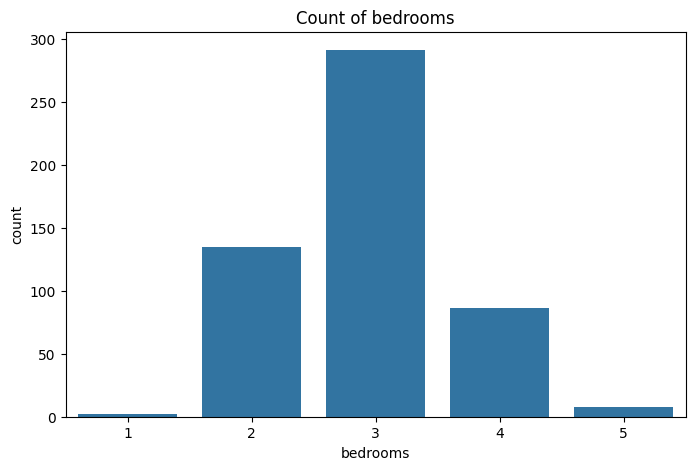

Correlation Matrix of Bivariate Analysis:
                                    price      area  bedrooms  bathrooms  \
price                            1.000000  0.526353  0.355370   0.491680   
area                             0.526353  1.000000  0.134125   0.177525   
bedrooms                         0.355370  0.134125  1.000000   0.342242   
bathrooms                        0.491680  0.177525  0.342242   1.000000   
stories                          0.440471  0.103331  0.414987   0.327793   
mainroad                         0.304622  0.295278 -0.025742   0.055741   
guestroom                        0.301040  0.195195  0.096721   0.141920   
basement                         0.174459  0.055870  0.124892   0.108690   
hotwaterheating                  0.089849 -0.037808  0.061433   0.072906   
airconditioning                  0.471996  0.239822  0.179644   0.228173   
parking                          0.326250  0.333412  0.114825   0.134540   
prefarea                         0.321236  0.2

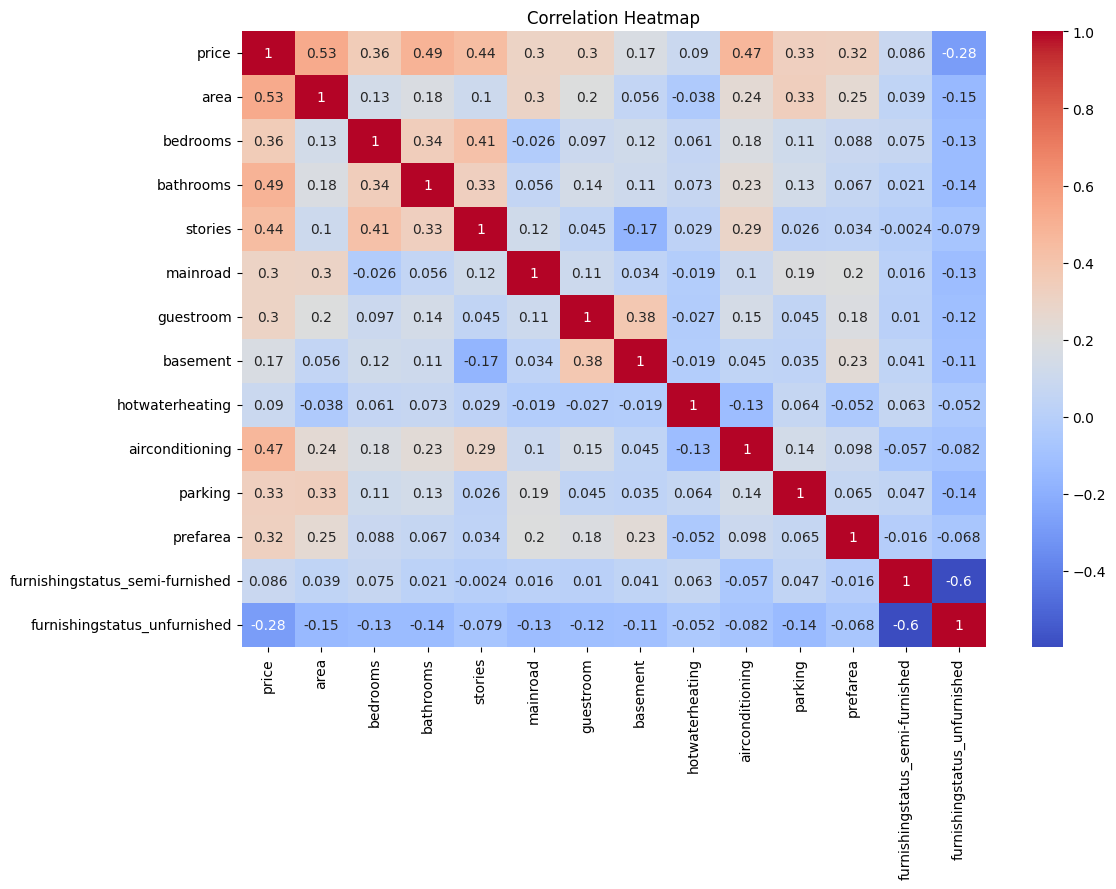

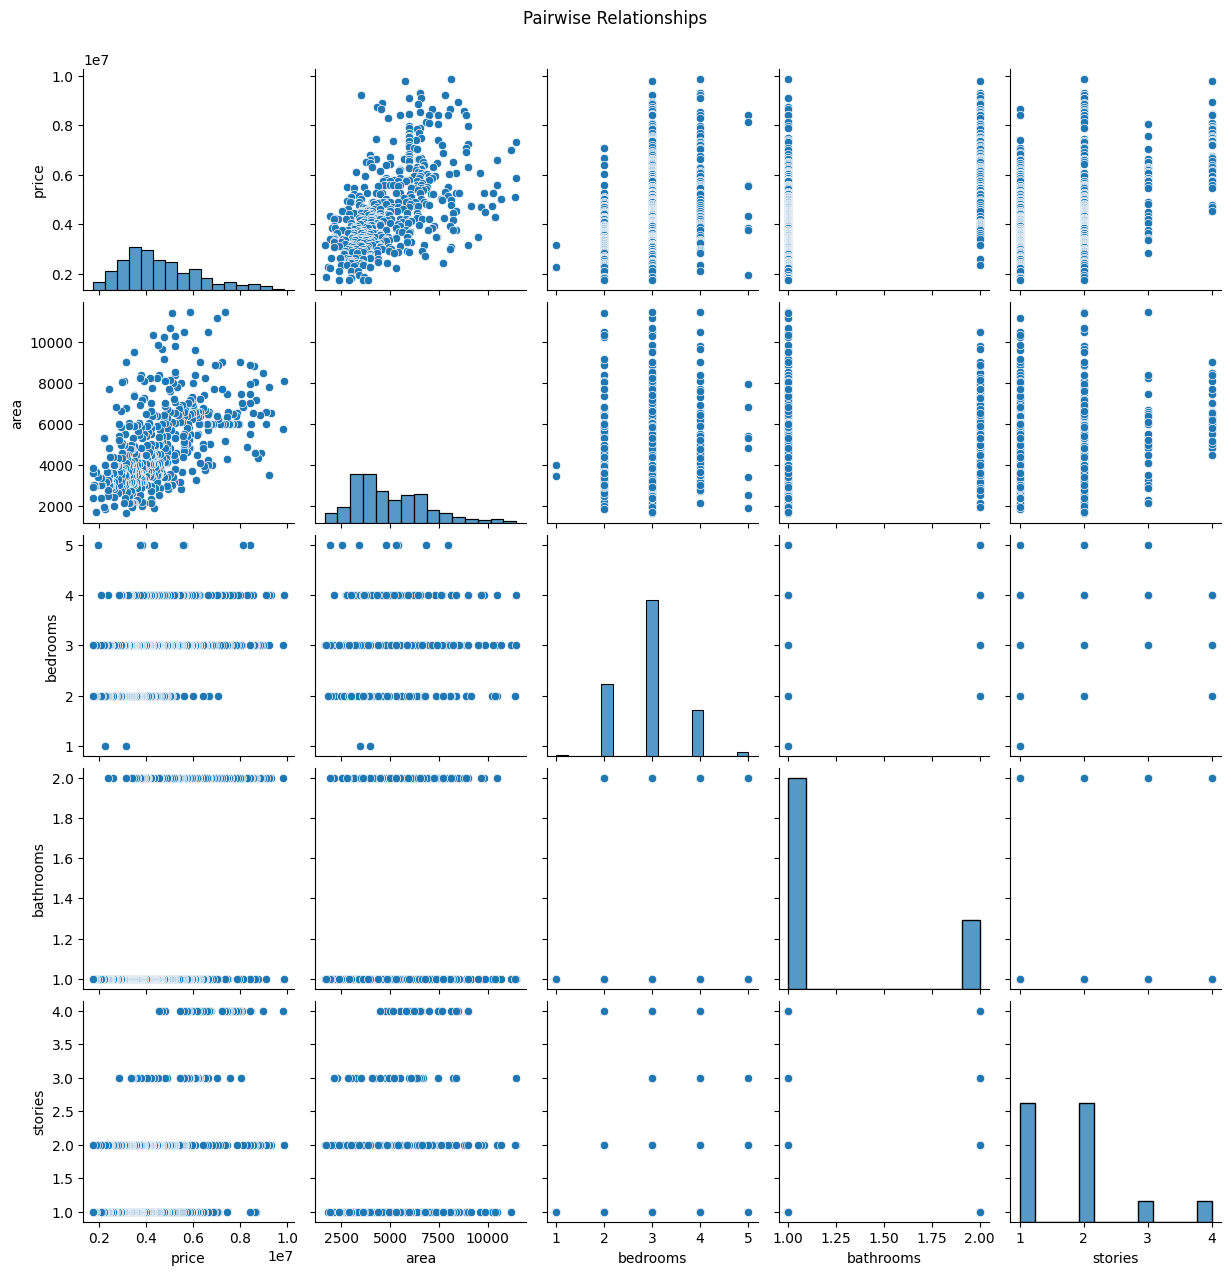

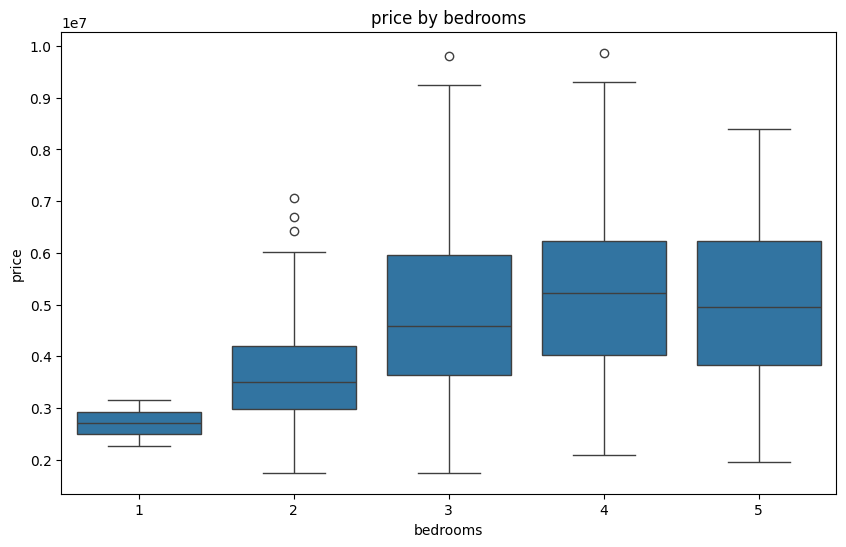

Model trained successfully!
 MAE: 1546453.62
R² Score: -0.09
Model, scaler, and columns saved to: models/svm_model.pkl


In [8]:
"""
Function: run_pipeline

Purpose:
---------
This function runs the entire machine learning pipeline step-by-step,
from loading and preprocessing the data to performing exploratory analysis,
training the model, evaluating it, and finally saving the trained model.

Reason:
--------
Wrapping the process in a function makes it reusable and organized.
Each section of the pipeline is modular and follows the standard ML lifecycle.
"""

def run_pipeline():
    # --------------------------
    # Step 1: Load and Preprocess Data
    # --------------------------
    # Load dataset and inspect different aspects such as head, tail, description, shape, and data types
    pre = DataPreprocessor('Housing.csv')
    pre.show_data(mode='info')
    print(pre.show_data(mode='head'))
    print(pre.show_data(mode='tail'))  
    print(pre.show_data(mode='describe'))
    print(pre.show_data(mode='shape'))
    print(pre.show_data(mode='columns'))
    print(pre.show_data(mode='datatypes'))
    print(pre.show_data(mode='sample'))

    # Remove outliers using z-score threshold and clean missing or irrelevant values
    pre.remove_outliers(z_thresh=3)
    pre.clean_data()

    # --------------------------
    # Step 2: Exploratory Data Analysis (EDA)
    # --------------------------
    # Run various data summary functions to understand data composition and quality
    eda = DataAnalyzer(pre.data)
    eda.data_types_summary()
    eda.missing_values_summary()
    eda.zero_values_summary()
    eda.value_counts_summary()
    eda.unique_values_summary()
    eda.feature_cardinality()
    eda.constant_columns()
    eda.duplicated_rows()
    eda.skewness_summary()
    eda.kurtosis_summary()
    eda.outlier_summary()

    # --------------------------
    # Step 3: Feature Scaling
    # --------------------------
    # Scale features using StandardScaler for uniformity and better SVM performance
    scaler = StandardScaler()
    pre.X = scaler.fit_transform(pre.X)

    # Save the feature column names for later use (e.g., during prediction)
    columns = pre.data.drop('price', axis=1).columns.tolist()

    # --------------------------
    # Step 4: Univariate Analysis
    # --------------------------
    # Perform and visualize univariate statistics and distributions
    uni = UnivariateAnalysis(pre.data)
    uni.summary_statistics()
    uni.plot_all_univariate()

    # --------------------------
    # Step 5: Bivariate Analysis
    # --------------------------
    # Explore relationships between pairs of variables and visualize them
    bi = BivariateAnalysis(pre.data)
    bi.correlation_matrix()
    bi.plot_all_bivariate()

    # --------------------------
    # Step 6: Train-Test Split
    # --------------------------
    # Split the dataset into training and testing sets for model evaluation
    X_train, X_test, y_train, y_test = train_test_split(pre.X, pre.y, test_size=0.2, random_state=42)

    # --------------------------
    # Step 7: Model Training and Evaluation
    # --------------------------
    # Train the SVR model, evaluate its performance, and save the trained model
    model_trainer = ModelTrainer(X_train, y_train, scaler, columns)
    model_trainer.train_model()
    model_trainer.evaluate(X_test, y_test)
    model_trainer.save_model('models/svm_model.pkl')  # Save model, scaler, and column info

# Run the full machine learning pipeline
run_pipeline()


In [2]:
a=input()
print(type(a))

<class 'str'>


In [4]:



choice = input("Which tables do you want to print? (even/odd): ").strip().lower()


if choice in ["even", "odd"]:
    start = 2 if choice == "even" else 1

    print(f"\n{choice.capitalize()} number tables from 1 to 10:\n")
    for num in range(start, 11, 2):
        print(f"Table of {num}")
        for i in range(1, 11):
            print(f"{num} x {i} = {num * i}")
        print()
else:
    print("Invalid input. Please enter 'even' or 'odd'.")




Even number tables from 1 to 10:

Table of 2
2 x 1 = 2
2 x 2 = 4
2 x 3 = 6
2 x 4 = 8
2 x 5 = 10
2 x 6 = 12
2 x 7 = 14
2 x 8 = 16
2 x 9 = 18
2 x 10 = 20

Table of 4
4 x 1 = 4
4 x 2 = 8
4 x 3 = 12
4 x 4 = 16
4 x 5 = 20
4 x 6 = 24
4 x 7 = 28
4 x 8 = 32
4 x 9 = 36
4 x 10 = 40

Table of 6
6 x 1 = 6
6 x 2 = 12
6 x 3 = 18
6 x 4 = 24
6 x 5 = 30
6 x 6 = 36
6 x 7 = 42
6 x 8 = 48
6 x 9 = 54
6 x 10 = 60

Table of 8
8 x 1 = 8
8 x 2 = 16
8 x 3 = 24
8 x 4 = 32
8 x 5 = 40
8 x 6 = 48
8 x 7 = 56
8 x 8 = 64
8 x 9 = 72
8 x 10 = 80

Table of 10
10 x 1 = 10
10 x 2 = 20
10 x 3 = 30
10 x 4 = 40
10 x 5 = 50
10 x 6 = 60
10 x 7 = 70
10 x 8 = 80
10 x 9 = 90
10 x 10 = 100

